***
***
***


## Apprentice Chef: Regression
A machine learning analysis

Analysis: [Marco Andre Remy Silva](https://www.linkedin.com/in/andremy)
Data set: Prof. Chase Kusterer
***
***
***

# Context
The company, Apprentice Chef, offers its busy customers the possibility to receive at their door a selection of daily-prepared meals together with a selection of disposable cookware for easy cleanup. Each meal takes 30 minutes to finish cooking at home, and the orders can be done through a user-friendly on-line platform and mobile app.

The following script focuses on analyzing a data set in order to build a machine learning regression model to predict the revenue of a client. This file contains the thought process that allowed me to reach to the final model that you can find in a python script in this same repository.

***
# Table of Content
1. [Initiation](#Initiation)
1. [Exploration Data Analysis](#Exploration-Data-Analysis)
1. [Data Cleaning]
1. [Feature Engineering]
1. [Model Selection]
1. [Next Steps]

***
# Initiation
## Importing libraries

First of all, I will import all the necessary libraries for the analysis. Even though I can import the libraries at any point in the code before using them, I rather do all the imports at the beginning to organize myself.

Here we can find libraries such as:
- [Pandas](https://pandas.pydata.org/docs/): Library for data manipulation and data analysis.
- [NumPy](https://numpy.org/doc/stable/contents.html): Library for mathematical and logical manipulation of multi-dimentional arrays and matrices.
- [SciPy](https://docs.scipy.org/doc/scipy-1.5.2/reference/tutorial/general.html): Support scientific computing for optimization, linear algebra, and more.
- [Matplotlib](https://matplotlib.org/3.3.1/users/index.html): 2-D and 3-D plotting. Works with NumPy.
- [Seaborn](https://seaborn.pydata.org/): Extended data visualization tool based on matplotlib.
- [scikit-learn](https://scikit-learn.org/stable/modules/classes.html): Machine learning library

In [160]:
import pandas            as pd
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing   import StandardScaler
from sklearn.neighbors       import KNeighborsClassifier        # KN-Neighbors
from sklearn.model_selection import GridSearchCV                # hyperparameter tuning
from sklearn.metrics         import make_scorer                 # customizable scorer

## Initializing global variables
Some global variables that will be used along the analysis.
- TEST_SIZE: Will be used to determine the size of the test data set when splitting the data.
- SEED: Will be used when splitting the data on training and test set to make the result reproducible and not depending on the variability of the randomization.
- scored_df: Data frame that will help store score of each model

In [161]:
TEST_SIZE = 0.25
SEED      = 222

score_df = pd.DataFrame(columns=["Model Name", "Train Score", "Test Score"])

## Functions
Creating a series of functions that will be used during the analysis to transform the data

In [162]:
# A dictionary that contains the informationo of which email domain falls into
# what category. It is used in the set_EmailType function.

email_type = {
    "professional" : [
        'mmm.com',
        'amex.com',
        'apple.com',
        'boeing.com',
        'caterpillar.com',
        'chevron.com',
        'cisco.com',
        'cocacola.com',
        'disney.com',
        'dupont.com',
        'exxon.com',
        'ge.org',
        'goldmansacs.com',
        'homedepot.com',
        'ibm.com',
        'intel.com',
        'jnj.com',
        'jpmorgan.com',
        'mcdonalds.com',
        'merck.com',
        'microsoft.com',
        'nike.com',
        'pfizer.com',
        'pg.com',
        'travelers.com',
        'unitedtech.com',
        'unitedhealth.com',
        'verizon.com',
        'visa.com',
        'walmart.com'
    ],
    "personal" : [
        'gmail.com',
        'yahoo.com',
        'protonmail.com'
    ],
    "junk" : [
        'me.com',
        'aol.com',
        'hotmail.com',
        'live.com',
        'msn.com',
        'passport.com'
    ]
}


def set_EmailType(email_domain):
    """
    It receives an email domain and returns if its can be considered a 
    professional, personal, or junk email
    
    Parameters
    ----------
    email_domain: The domain of the email without the "@".
    
    Returns
    -------
    return: Returns a string with the category infered from the email_domain.
    It can be professional, personal or junk.
    """
    result = ""
    for key in email_type.keys():
        if email_domain in email_type[key]:
            result = key
            break
    return result


def flag_Dataset(target_df, flagging):
    """
    
    """
    for key in flagging:
        for flag in flagging[key]:
            i = 0
            sign = flag[0]
            value = flag[1]

            new_feature = f"{key}_flag_{i}"
            target_df.loc[:, new_feature] = 0

            if sign == '>':
                target_df.loc[
                    target_df[key] > value,
                    new_feature
                ] = 1
            elif sign == '>=':
                target_df.loc[
                    target_df[key] >= value,
                    new_feature
                ] = 1
            elif sign == '<':
                target_df.loc[
                    target_df[key] < value,
                    new_feature
                ] = 1
            elif sign == '<=':
                flagged_df.loc[
                    flagged_df[key] <= value,
                    new_feature
                ] = 1
            elif sign == '==':
                target_df.loc[
                    target_df[key] == value,
                    new_feature
                ] = 1

            all_features['flags'] += [new_feature]

            i += 1

***
# Exploration Data Analysis
## Loading the data
Now, I load the dataset stored in the file *data/Apprentice_Chef_Dataset.xlsx* to a variable called **original_df**

In [163]:
original_df = pd.read_excel("data/Apprentice_Chef_Dataset.xlsx")
original_df.head(10)

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,1880.0,1,Addam Osgrey,addam.osgrey@passport.com,Addam,Osgrey,118,4,7,5,...,2,1,0,90,165.8,6,1,3,11,0
1,1495.0,1,Aegon Blackfyre,aegon.blackfyre@jnj.com,Aegon,Blackfyre,44,3,6,3,...,4,1,0,90,150.5,4,1,3,13,90
2,2572.5,1,Aegon Frey (son of Aenys),aegon.frey.(son.of.aenys)@gmail.com,Aegon,Frey,38,1,5,3,...,0,0,0,80,99.6,3,0,3,12,0
3,1647.0,1,Aegon Targaryen (son of Rhaegar),aegon.targaryen.(son.of.rhaegar)@ibm.com,Aegon,Targaryen,76,3,8,10,...,4,0,0,90,125.0,3,0,3,13,0
4,1923.0,1,Aegon V Targaryen,aegon.v.targaryen@goldmansacs.com,Aegon,V Targaryen,65,3,6,9,...,4,1,0,90,135.3,3,1,3,13,253
5,1250.0,1,Aegor Rivers,aegor.rivers@gmail.com,Aegor,Rivers,57,4,6,2,...,5,0,0,70,91.2,3,1,2,17,0
6,4665.0,1,Aelinor Penrose,aelinor.penrose@homedepot.com,Aelinor,Penrose,106,3,10,8,...,3,0,0,70,263.3,6,2,4,10,705
7,1690.0,1,Aemma Arryn,aemma.arryn@yahoo.com,Aemma,Arryn,122,6,8,10,...,3,0,0,70,160.0,5,1,3,13,0
8,1710.0,1,Aemon Rivers,aemon.rivers@caterpillar.com,Aemon,Rivers,46,4,5,10,...,10,1,1,70,170.1,4,2,3,12,0
9,1770.0,1,Aggar,aggar@protonmail.com,Aggar,Aggar,58,4,6,5,...,7,1,1,90,191.3,7,1,3,12,0


Each observation in the data set represents a single user, and each column contains the cumulative information from 12 consecutive months. Given that for this analysis I will be predicting the revenue, I will separate the variables as follows.

**Dependent Variable**
- REVENUE: The cumulative revenue that the user has brought in the past 12 months.

**Independent Variables**

<!--
- CROSS_SELL_SUCCESS: 1 if the customer has accepted the cross-selling promotion. 0 if the customer hasn't.
- NAME: Full name of the customer.
- EMAIL: Email of the customer.
- FIRST_NAME: First name of the customer.
- FAMILY_NAME: Last name of the customer.
- TOTAL_MEALS_ORDERED: Cumulative number of meals ordered by the client.
- UNIQUE_MEALS_PURCH: Number of unique meals. This number increase with every new meal ordered (a meal that hasn't been ordered before by that user).
- CONTACTS_W_CUSTOMER_SERVICE: How many times the user has contacted customer service. This can be either to complain, to make a special request, or to ask for information.
- PRODUCT_CATEGORIES_VIEWED: The number of product categories viewed by the client.
- AVG_TIME_PER_SITE_VISIT: The average user's session time (or mobile app) that could've either finished in a purchased or not.
- MOBILE_NUMBER: 1 if the customer has registered his/her mobile number, 0 if he/she hasn't.
- CANCELLATIONS_BEFORE_NOON: Number of cancellations done before noon (which are free cancelations).
- CANCELLATIONS_AFTER_NOON: Number of cancellations done after noon (50% refund).
- TASTES_AND_PREFERENCES: 1 if the customer has registered his/her tastes and preferences, 0 if he/she hasn't.
- MOBILE_LOGINS: Number of logins made on the mobile app.
- PC_LOGINS: Number of logins made on the web platform.
- WEEKLY_PLAN: Number of times customer ordered the weekly plan
- EARLY_DELIVERIES: Number of times the customer has received his/her meal before the delivery window.
- LATE_DELIVERIES: Number of times the customer has received his/her meal after the delivery window.
- PACKAGE_LOCKER: 1 if the customers' building has a package locker, 0 if he/she doesn't.
- REFRIGERATED_LOCKER: 1 if the customers' building has a refrigerated locker, 0 if he/she doesn't.
- FOLLOWED_RECOMMENDATIONS_PCT: The percentage of time the customer has followed the meal recommendation generated by the company's algorithm for them.
- AVG_PREP_VID_TIME: Average time in seconds the meal prep video was played.
- LARGEST_ORDER_SIZE: Largest number of meals ordered in a single order.
- MASTER_CLASSES_ATTENDED: Number of master classes attended by the customer.
- MEDIAN_MEAL_RATING: Median rating that the customer has given to his/her meals.
- AVG_CLICKS_PER_VISIT: Average number of clicks done by the customer per visit.
- TOTAL_PHOTOS_VIEWED: Total number of clicks on photos done by the customer.
-->

- Binary Variables:
    - CROSS_SELL_SUCCESS: 1 if the customer has accepted the cross-selling promotion. 0 if the customer hasn't.
    - MOBILE_NUMBER: 1 if the customer has registered his/her mobile number, 0 if he/she hasn't.
    - TASTES_AND_PREFERENCES: 1 if the customer has registered his/her tastes and preferences, 0 if he/she hasn't.
    - PACKAGE_LOCKER: 1 if the customers' building has a package locker, 0 if he/she doesn't.
    - REFRIGERATED_LOCKER: 1 if the customers' building has a refrigerated locker, 0 if he/she doesn't.


- Discrete Variables:
    - TOTAL_MEALS_ORDERED: Cumulative number of meals ordered by the client.
    - UNIQUE_MEALS_PURCH: Number of unique meals. This number increase with every new meal ordered (a meal that hasn't been ordered before by that user).
    - CONTACTS_W_CUSTOMER_SERVICE: How many times the user has contacted customer service. This can be either to complain, to make a special request, or to ask for information.
    - PRODUCT_CATEGORIES_VIEWED: The number of product categories viewed by the client.
    - CANCELLATIONS_BEFORE_NOON: Number of cancellations done before noon (which are free cancelations).
    - CANCELLATIONS_AFTER_NOON: Number of cancellations done after noon (50% refund).
    - MOBILE_LOGINS: Number of logins made on the mobile app.
    - PC_LOGINS: Number of logins made on the web platform.
    - WEEKLY_PLAN: Number of times customer ordered the weekly plan
    - EARLY_DELIVERIES: Number of times the customer has received his/her meal before the delivery window.
    - LATE_DELIVERIES: Number of times the customer has received his/her meal after the delivery window.
    - LARGEST_ORDER_SIZE: Largest number of meals ordered in a single order.
    - MASTER_CLASSES_ATTENDED: Number of master classes attended by the customer.
    - MEDIAN_MEAL_RATING: Median rating that the customer has given to his/her meals.
    - TOTAL_PHOTOS_VIEWED: Total number of clicks on photos done by the customer.


- Continuous Variables:
    - AVG_TIME_PER_SITE_VISIT: The average user's session time (or mobile app) that could've either finished in a purchased or not.
    - FOLLOWED_RECOMMENDATIONS_PCT: The percentage of time the customer has followed the meal recommendation generated by the company's algorithm for them.
    - AVG_PREP_VID_TIME: Average time in seconds the meal prep video was played.
    - AVG_CLICKS_PER_VISIT: Average number of clicks done by the customer per visit.


- Other Variables:
    - NAME: Full name of the customer.
    - EMAIL: Email of the customer.
    - FIRST_NAME: First name of the customer.
    - FAMILY_NAME: Last name of the customer.

**Note**: The exercise of this analysis is to narrow down what are the independent variables that will more accurately predict the revenue. Hence, this list of independent variables is my starting point.

Now, I am declaring a dictionary that will help me easily access a group of features (variables) according to its type.  

In [164]:
# Dependent variables

dependent_variable = "REVENUE"


# A dictionary that will quickly help identify what features are binary, 
# discrete, continuous, or other

default_features = {
    "binary": [
        "CROSS_SELL_SUCCESS",
        "MOBILE_NUMBER",
        "TASTES_AND_PREFERENCES",
        "PACKAGE_LOCKER",
        "REFRIGERATED_LOCKER"
    ],
    "discrete": [
        "TOTAL_MEALS_ORDERED",
        "UNIQUE_MEALS_PURCH",
        "CONTACTS_W_CUSTOMER_SERVICE",
        "PRODUCT_CATEGORIES_VIEWED",
        "CANCELLATIONS_BEFORE_NOON",
        "CANCELLATIONS_AFTER_NOON",
        "MOBILE_LOGINS",
        "PC_LOGINS",
        "WEEKLY_PLAN",
        "EARLY_DELIVERIES",
        "LATE_DELIVERIES",
        "LARGEST_ORDER_SIZE",
        "MASTER_CLASSES_ATTENDED",
        "MEDIAN_MEAL_RATING",
        "TOTAL_PHOTOS_VIEWED"
    ],
    "continuous": [
        "AVG_TIME_PER_SITE_VISIT",
        "FOLLOWED_RECOMMENDATIONS_PCT",
        "AVG_PREP_VID_TIME",
        "AVG_CLICKS_PER_VISIT",
    ],
    "other": [
        "NAME",
        "EMAIL",
        "FIRST_NAME",
        "FAMILY_NAME"
    ]
}

## Info
Checking the data type of each column

In [165]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REVENUE                       1946 non-null   float64
 1   CROSS_SELL_SUCCESS            1946 non-null   int64  
 2   NAME                          1946 non-null   object 
 3   EMAIL                         1946 non-null   object 
 4   FIRST_NAME                    1946 non-null   object 
 5   FAMILY_NAME                   1899 non-null   object 
 6   TOTAL_MEALS_ORDERED           1946 non-null   int64  
 7   UNIQUE_MEALS_PURCH            1946 non-null   int64  
 8   CONTACTS_W_CUSTOMER_SERVICE   1946 non-null   int64  
 9   PRODUCT_CATEGORIES_VIEWED     1946 non-null   int64  
 10  AVG_TIME_PER_SITE_VISIT       1946 non-null   float64
 11  MOBILE_NUMBER                 1946 non-null   int64  
 12  CANCELLATIONS_BEFORE_NOON     1946 non-null   int64  
 13  CAN

## Null Values
Looking for null values in the data

In [166]:
original_df.isna().sum()

REVENUE                          0
CROSS_SELL_SUCCESS               0
NAME                             0
EMAIL                            0
FIRST_NAME                       0
FAMILY_NAME                     47
TOTAL_MEALS_ORDERED              0
UNIQUE_MEALS_PURCH               0
CONTACTS_W_CUSTOMER_SERVICE      0
PRODUCT_CATEGORIES_VIEWED        0
AVG_TIME_PER_SITE_VISIT          0
MOBILE_NUMBER                    0
CANCELLATIONS_BEFORE_NOON        0
CANCELLATIONS_AFTER_NOON         0
TASTES_AND_PREFERENCES           0
MOBILE_LOGINS                    0
PC_LOGINS                        0
WEEKLY_PLAN                      0
EARLY_DELIVERIES                 0
LATE_DELIVERIES                  0
PACKAGE_LOCKER                   0
REFRIGERATED_LOCKER              0
FOLLOWED_RECOMMENDATIONS_PCT     0
AVG_PREP_VID_TIME                0
LARGEST_ORDER_SIZE               0
MASTER_CLASSES_ATTENDED          0
MEDIAN_MEAL_RATING               0
AVG_CLICKS_PER_VISIT             0
TOTAL_PHOTOS_VIEWED 

The only attribute (feature) that has null values is the Family Name (or Last Name). I don't believe this is going to be a relevant information to predict revenue. So, I won't take any immediate action on the observations with empty last name.

## Describe
Analyzing the basic statistics of every numerical variable

In [167]:
original_df.describe()

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,...,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,...,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,2107.292652,0.678828,74.634121,4.904933,6.983556,5.383864,99.604651,0.877698,1.404933,0.165982,...,2.970709,0.355087,0.113052,35.411100,150.556578,4.436793,0.604317,2.794964,13.508222,106.433710
std,1138.290709,0.467047,55.309782,2.502175,2.281193,3.044001,62.341756,0.327719,1.549677,0.432241,...,2.744598,0.478663,0.316738,26.577927,49.447180,1.550972,0.641866,0.756528,2.333876,181.014124
min,131.000000,0.000000,11.000000,1.000000,1.000000,1.000000,10.330000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,33.400000,0.000000,0.000000,1.000000,5.000000,0.000000
25%,1350.000000,0.000000,39.000000,3.000000,5.000000,3.000000,72.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,10.000000,114.400000,3.000000,0.000000,2.000000,12.000000,0.000000
50%,1740.000000,1.000000,60.000000,5.000000,7.000000,5.000000,94.160000,1.000000,1.000000,0.000000,...,2.000000,0.000000,0.000000,30.000000,145.600000,4.000000,1.000000,3.000000,13.000000,0.000000
75%,2670.000000,1.000000,95.000000,7.000000,8.000000,8.000000,117.287500,1.000000,2.000000,0.000000,...,4.000000,1.000000,0.000000,60.000000,173.775000,5.000000,1.000000,3.000000,15.000000,174.000000
max,8793.750000,1.000000,493.000000,19.000000,18.000000,10.000000,1645.600000,1.000000,13.000000,3.000000,...,19.000000,1.000000,1.000000,90.000000,564.200000,11.000000,3.000000,5.000000,19.000000,1600.000000


## Removing dirty data
From the data shown before I see some records that have inconsistent information according to how the data was supposed to be extracted.

1. LARGEST_ORDER_SIZE: It is expected to have values with at least 1 and greater. Nonetheless, one record has a value of 0. I will remove this observation from the data set.

In [168]:
# Keeping only observations with a LARGEST_ORDER_SIZE greater than 0

original_df = original_df[original_df['LARGEST_ORDER_SIZE'] > 0]

## Correltion

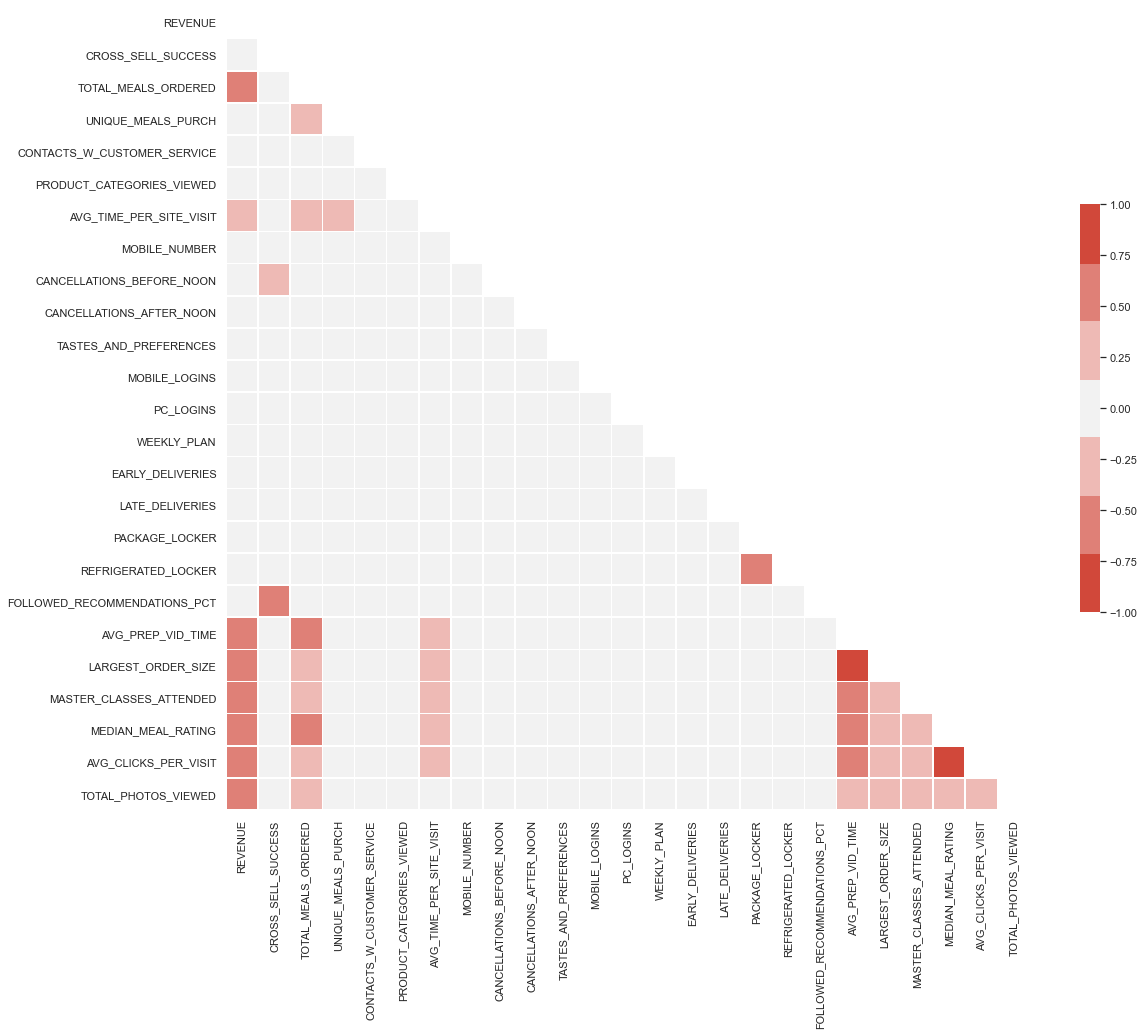

REVENUE                         1.000000
CROSS_SELL_SUCCESS              0.005077
TOTAL_MEALS_ORDERED             0.600175
UNIQUE_MEALS_PURCH             -0.062489
CONTACTS_W_CUSTOMER_SERVICE     0.103552
PRODUCT_CATEGORIES_VIEWED       0.035709
AVG_TIME_PER_SITE_VISIT         0.144040
MOBILE_NUMBER                   0.031555
CANCELLATIONS_BEFORE_NOON       0.014434
CANCELLATIONS_AFTER_NOON       -0.034656
TASTES_AND_PREFERENCES          0.008342
MOBILE_LOGINS                   0.015442
PC_LOGINS                      -0.018419
WEEKLY_PLAN                     0.009155
EARLY_DELIVERIES               -0.001431
LATE_DELIVERIES                -0.008862
PACKAGE_LOCKER                 -0.011224
REFRIGERATED_LOCKER            -0.000575
FOLLOWED_RECOMMENDATIONS_PCT   -0.019592
AVG_PREP_VID_TIME               0.643048
LARGEST_ORDER_SIZE              0.434153
MASTER_CLASSES_ATTENDED         0.448650
MEDIAN_MEAL_RATING              0.607269
AVG_CLICKS_PER_VISIT           -0.553292
TOTAL_PHOTOS_VIE

In [169]:
# Generating Correlations
corr = original_df.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(15, 15, n=7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Displaying map
plt.show()

print(corr['REVENUE'])

# LARGEST_ORDER_SIZE -- (-)AVG_PREP_VID_TIME
# MEDIAN_MEAL_RATING -- (-)AVG_CLICKS_PER_VISIT

In [170]:
original_df.drop(
    columns=['AVG_PREP_VID_TIME', 'AVG_CLICKS_PER_VISIT'], 
    axis=1, 
    inplace=True
)

default_features['continuous'].remove('AVG_PREP_VID_TIME')
default_features['continuous'].remove('AVG_CLICKS_PER_VISIT')
# This also remove the features in the all_features dictionary

In [171]:
features = default_features['continuous'] + default_features['discrete'] + default_features['binary']

for feat in features:
    print(f"Values of {feat}")
    print(original_df[feat].value_counts().sort_values(ascending=False))
    print("*" * 40)

Values of AVG_TIME_PER_SITE_VISIT
48.00     11
49.00     10
36.00     10
100.00    10
96.00     10
          ..
76.54      1
109.36     1
104.60     1
76.64      1
75.62      1
Name: AVG_TIME_PER_SITE_VISIT, Length: 1454, dtype: int64
****************************************
Values of FOLLOWED_RECOMMENDATIONS_PCT
10    403
20    361
30    242
70    190
0     155
60    150
80    142
50    140
40     97
90     65
Name: FOLLOWED_RECOMMENDATIONS_PCT, dtype: int64
****************************************
Values of TOTAL_MEALS_ORDERED
15     58
13     57
14     53
50     34
40     30
       ..
297     1
301     1
24      1
316     1
493     1
Name: TOTAL_MEALS_ORDERED, Length: 230, dtype: int64
****************************************
Values of UNIQUE_MEALS_PURCH
3     338
4     260
6     225
5     214
7     205
8     179
1     173
2     170
9     162
10      7
12      4
11      3
13      3
18      1
19      1
Name: UNIQUE_MEALS_PURCH, dtype: int64
****************************************
Va

## Data distribution per variable (Histograms)

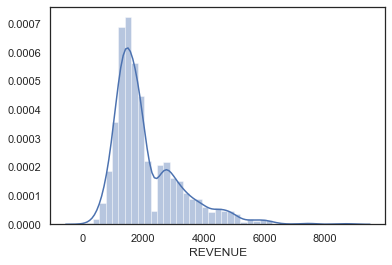

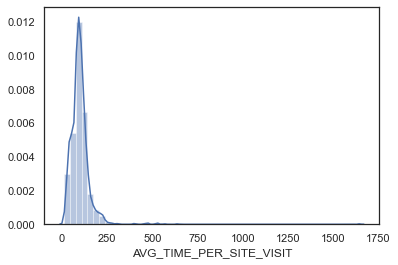

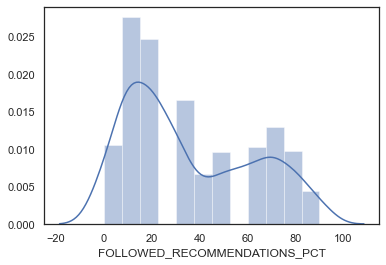

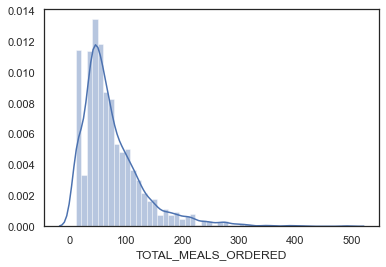

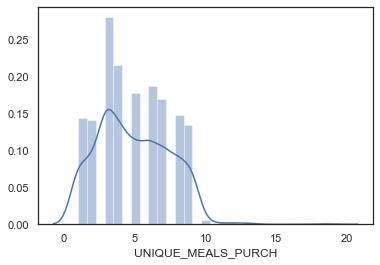

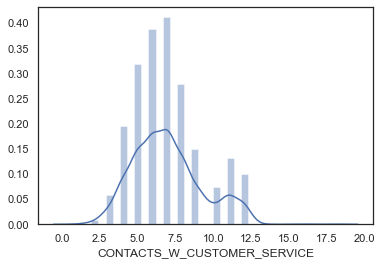

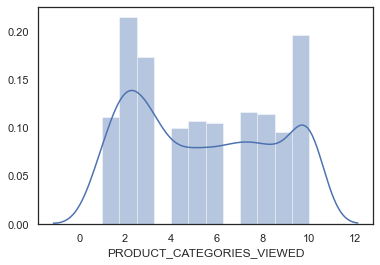

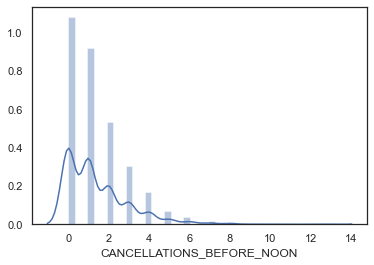

C:\Users\Andre\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


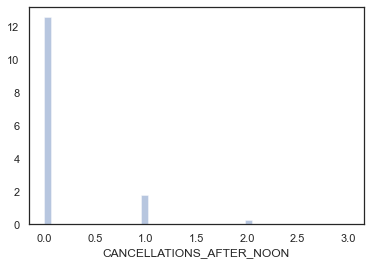

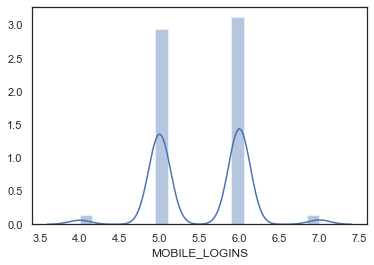

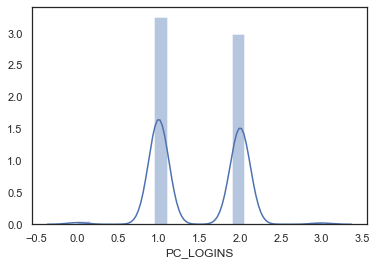

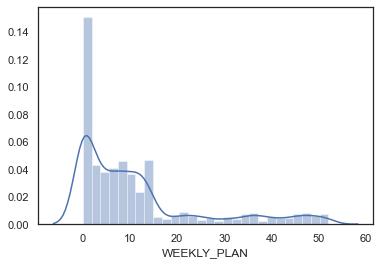

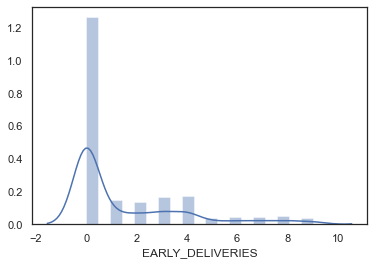

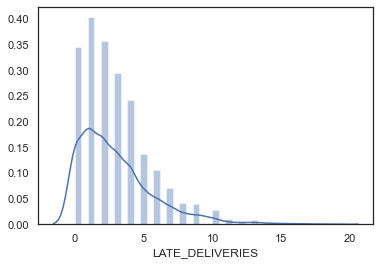

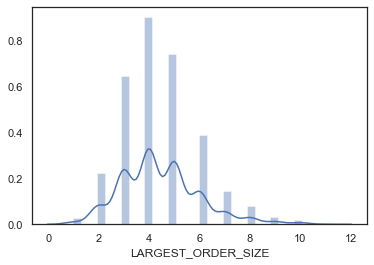

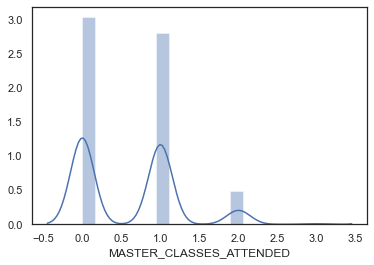

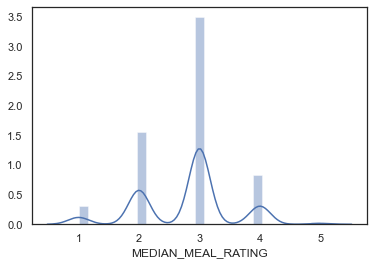

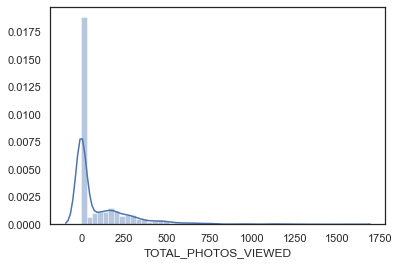

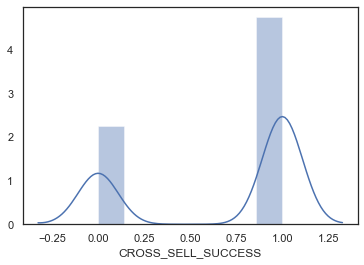

C:\Users\Andre\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


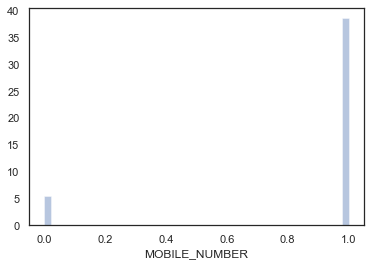

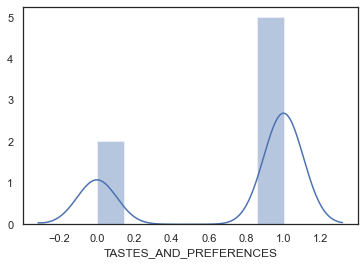

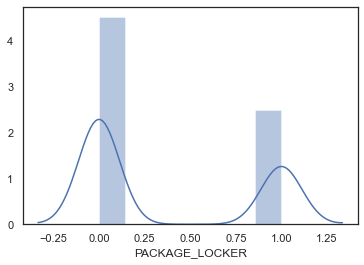

C:\Users\Andre\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


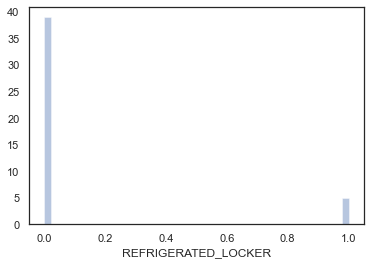

In [147]:
histogram_feat = default_features["discrete"] + default_features["continuous"]

sns.distplot(original_df[dependent_variable])
plt.show()

for feature in features:
    sns.distplot(original_df[feature])
    plt.show()

# Flagging Trends

In [184]:
flagged_df = original_df.copy()
all_features = default_features.copy()
all_features["flags"] = []
all_features["new_features"] = []

flagging = {
    'TOTAL_MEALS_ORDERED': [
        ['>',25]
    ],
    'CONTACTS_W_CUSTOMER_SERVICE':[
        ['>', 10]
    ]
}

flag_Dataset(flagged_df, flagging)

## Scatter plots

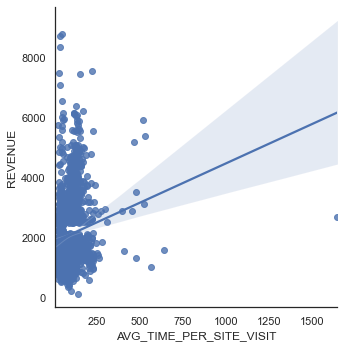

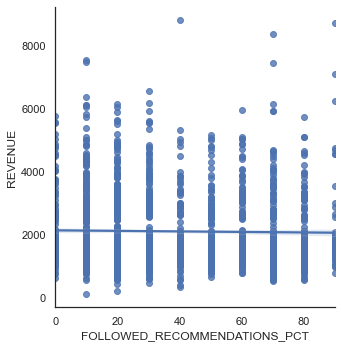

Hue by: TOTAL_MEALS_ORDERED_flag_0


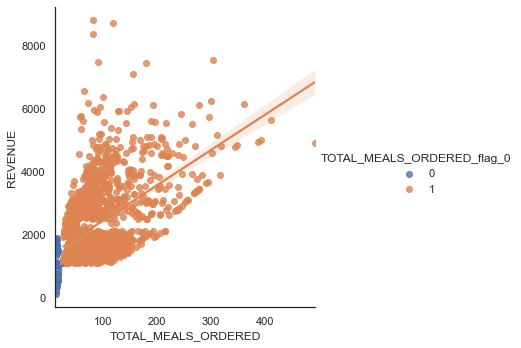

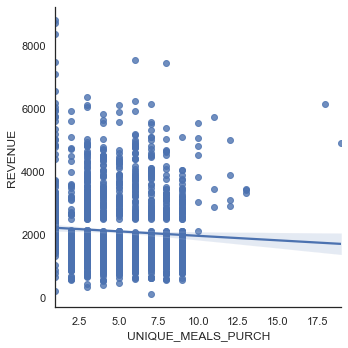

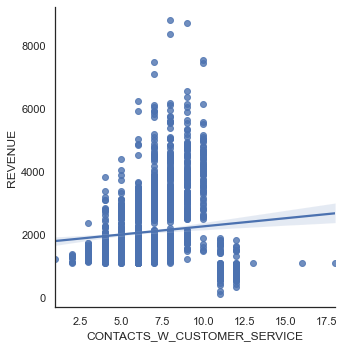

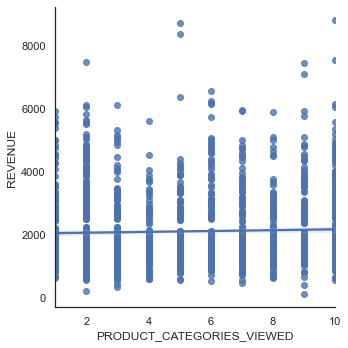

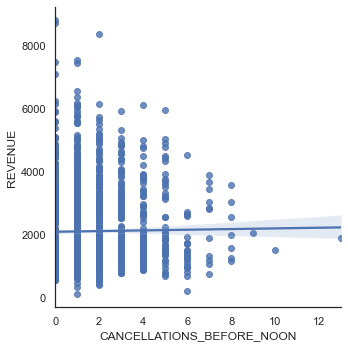

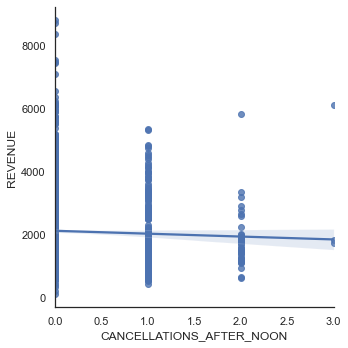

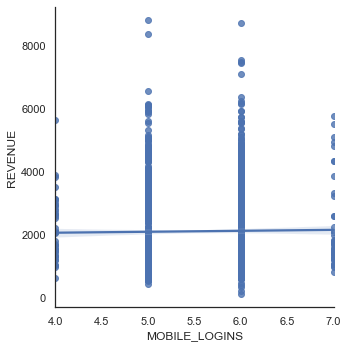

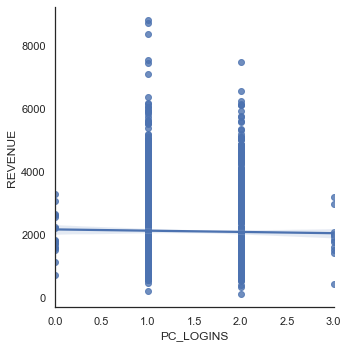

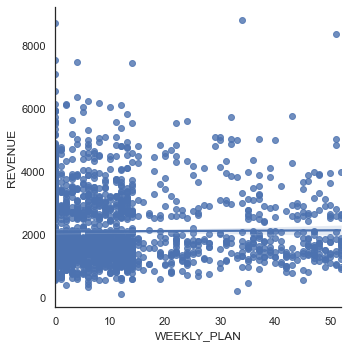

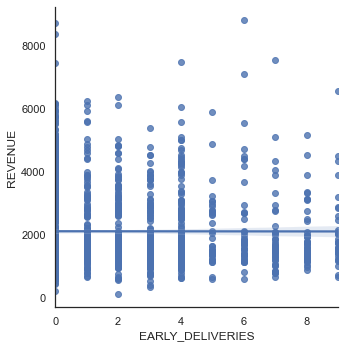

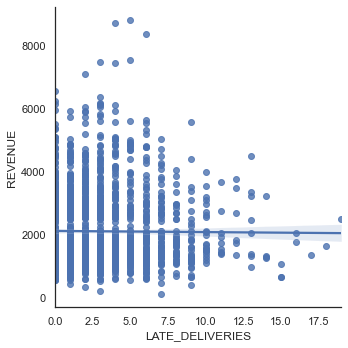

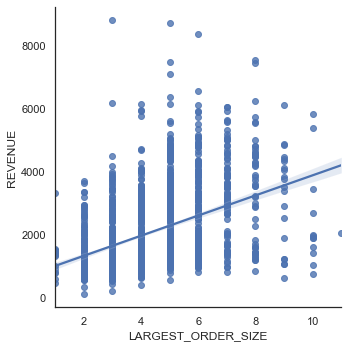

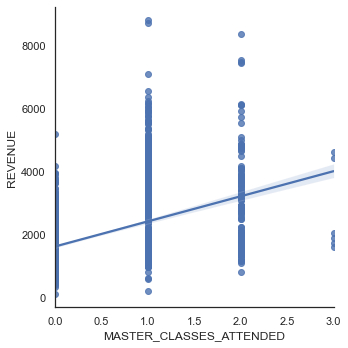

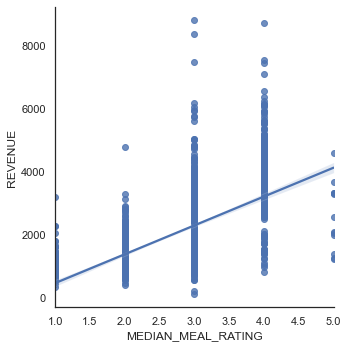

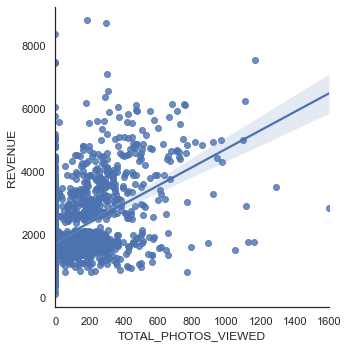

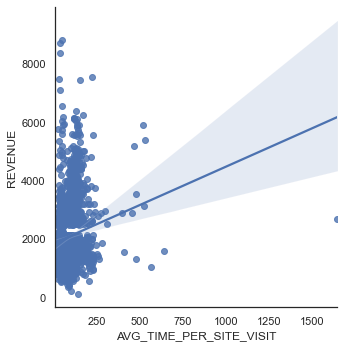

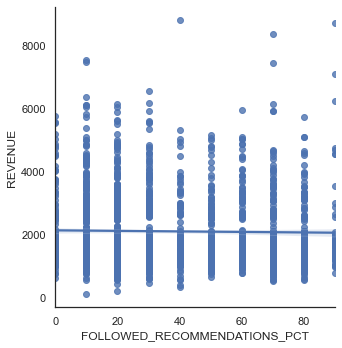

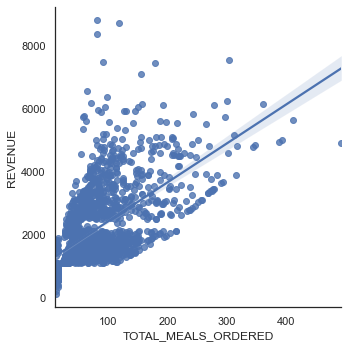

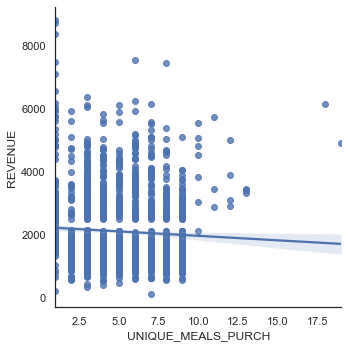

Hue by: CONTACTS_W_CUSTOMER_SERVICE_flag_0


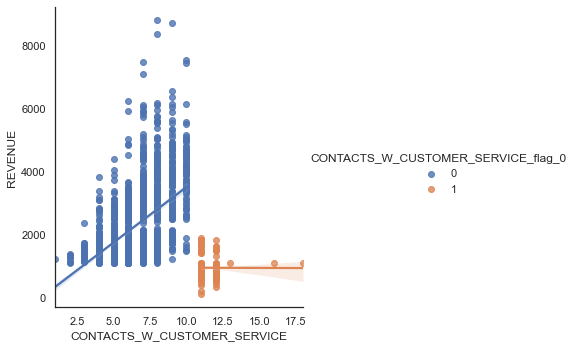

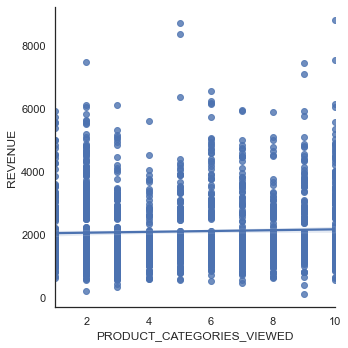

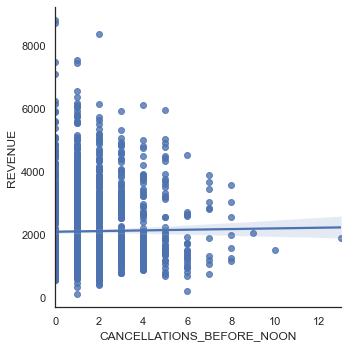

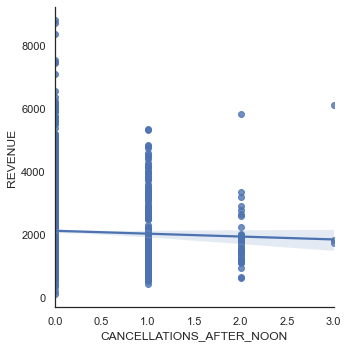

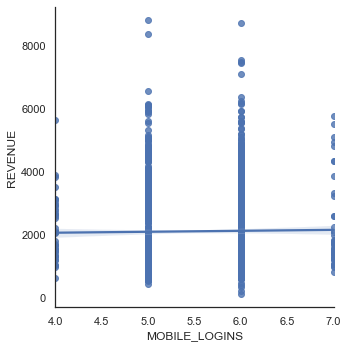

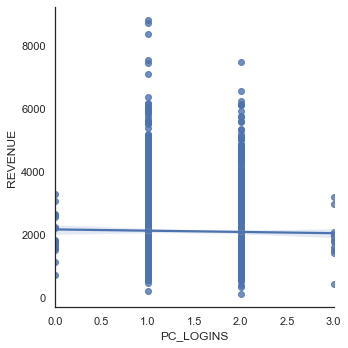

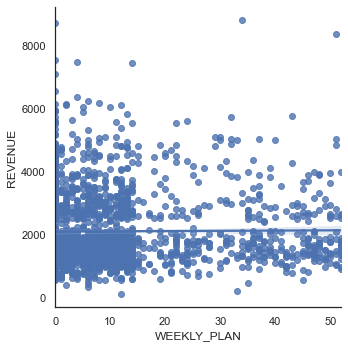

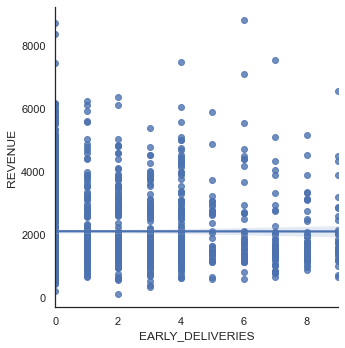

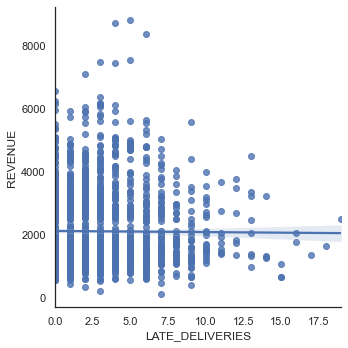

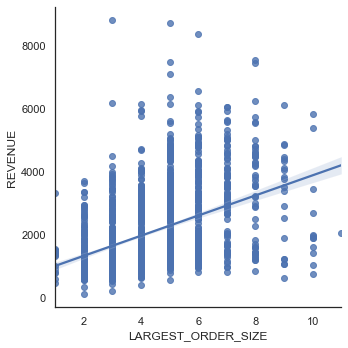

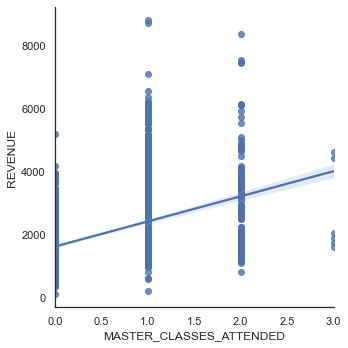

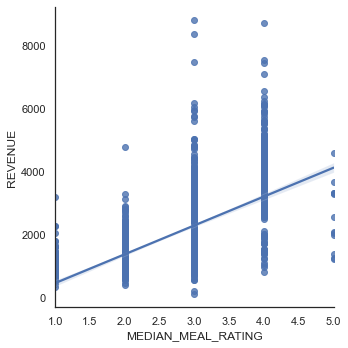

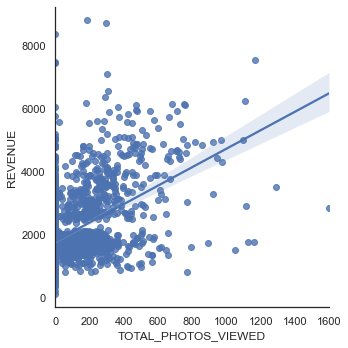

In [192]:
scatter_feat = all_features['continuous'] + all_features['discrete']

for flag in all_features['flags']:
    for feature in scatter_feat:
        if feature in flag:
            print(f"Hue by: {flag}")
            sns.lmplot(
                data=flagged_df,
                x=feature, 
                y=dependent_variable,
                hue=flag
            )
        else:
            sns.lmplot(
                data=flagged_df,
                x=feature, 
                y=dependent_variable
            )
        plt.show()

<h1>Plotting the numerical columns</h1>

Variable: TOTAL_MEALS_ORDERED
------------------------------
15     58
13     57
14     54
50     34
40     30
       ..
221     1
228     1
231     1
233     1
493     1
Name: TOTAL_MEALS_ORDERED, Length: 230, dtype: int64


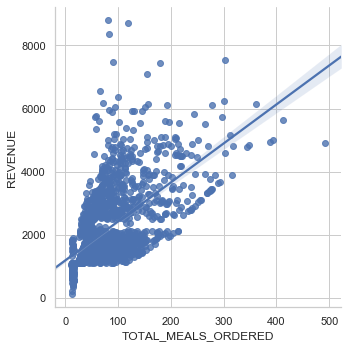

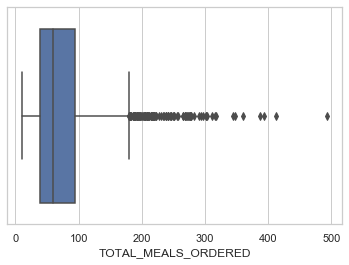

Variable: UNIQUE_MEALS_PURCH
------------------------------
3     338
4     260
6     226
5     214
7     205
8     179
1     173
2     170
9     162
10      7
12      4
13      3
11      3
19      1
18      1
Name: UNIQUE_MEALS_PURCH, dtype: int64


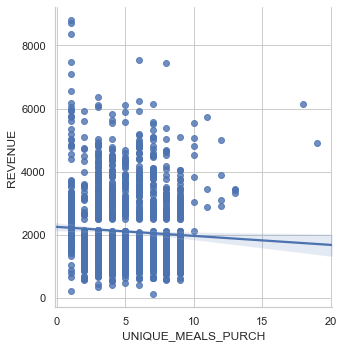

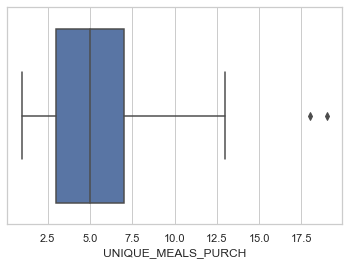

Variable: CONTACTS_W_CUSTOMER_SERVICE
------------------------------
7     378
6     356
5     292
8     256
4     180
9     138
11    121
12     92
10     68
3      53
2       8
18      1
16      1
13      1
1       1
Name: CONTACTS_W_CUSTOMER_SERVICE, dtype: int64


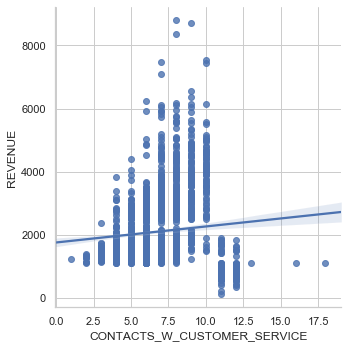

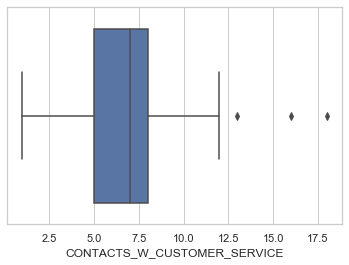

Variable: AVG_TIME_PER_SITE_VISIT
------------------------------
48.00     12
49.00     10
36.00     10
100.00    10
96.00     10
          ..
175.35     1
83.92      1
26.16      1
112.29     1
74.41      1
Name: AVG_TIME_PER_SITE_VISIT, Length: 1454, dtype: int64


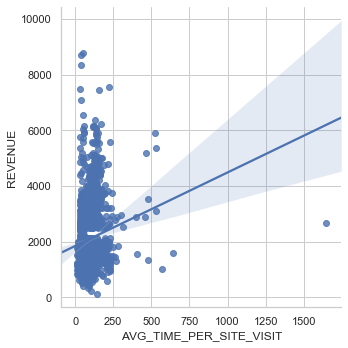

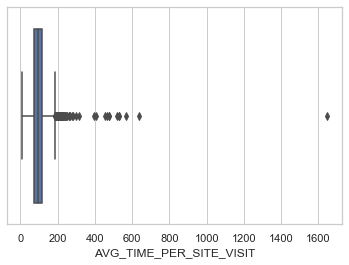

Variable: PC_LOGINS
------------------------------
1    999
2    919
0     16
3     12
Name: PC_LOGINS, dtype: int64


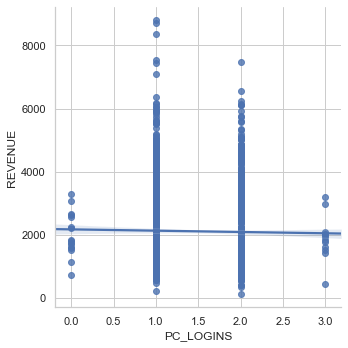

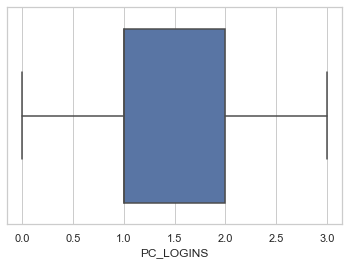

Variable: WEEKLY_PLAN
------------------------------
0     468
8      93
13     88
12     85
14     82
2      82
11     78
1      78
3      75
7      75
6      73
9      73
4      71
5      66
10     55
22     19
37     18
52     17
35     16
47     16
24     15
46     14
15     14
36     13
50     13
48     13
45     13
21     13
19     12
26     11
25     11
31     11
51     11
39     10
38     10
34     10
20     10
43      9
30      9
40      9
42      9
49      9
23      8
32      8
28      8
18      7
41      7
44      7
17      6
27      6
33      5
16      5
29      2
Name: WEEKLY_PLAN, dtype: int64


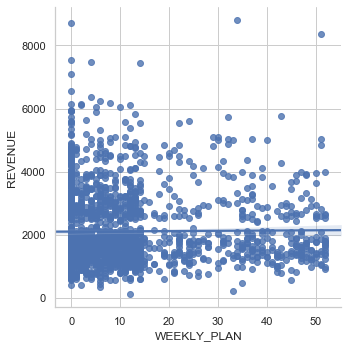

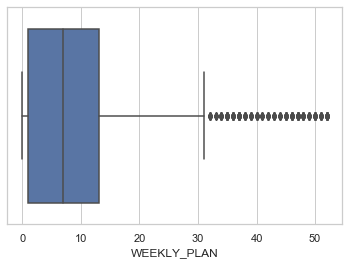

Variable: PACKAGE_LOCKER
------------------------------
0    1255
1     691
Name: PACKAGE_LOCKER, dtype: int64


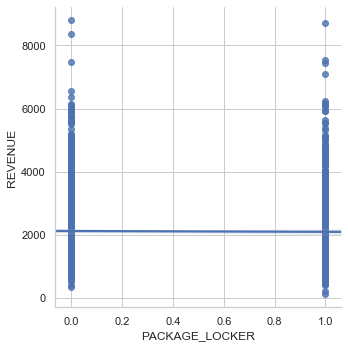

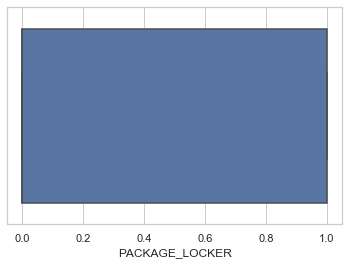

Variable: AVG_PREP_VID_TIME
------------------------------
86.4     28
104.0    14
109.2    14
120.0    13
145.6    13
         ..
232.9     1
165.4     1
90.8      1
100.2     1
211.3     1
Name: AVG_PREP_VID_TIME, Length: 1038, dtype: int64


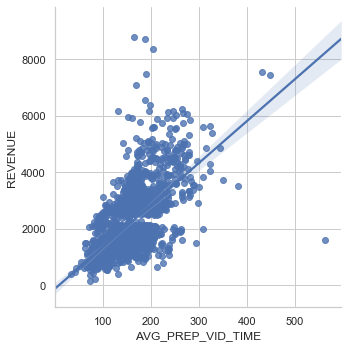

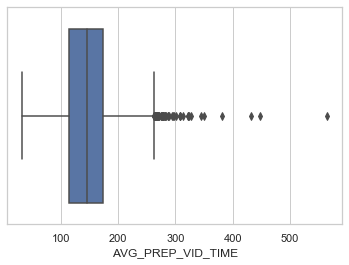

Variable: LARGEST_ORDER_SIZE
------------------------------
4     547
5     449
3     391
6     236
2     135
7      89
8      49
9      20
1      16
10     12
11      1
0       1
Name: LARGEST_ORDER_SIZE, dtype: int64


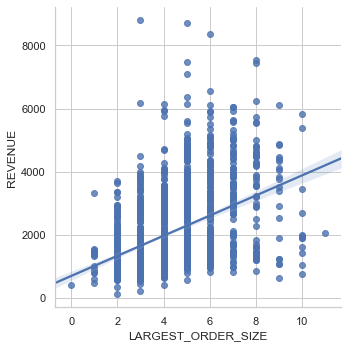

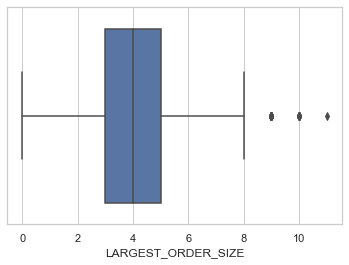

Variable: MASTER_CLASSES_ATTENDED
------------------------------
0    932
1    858
2    150
3      6
Name: MASTER_CLASSES_ATTENDED, dtype: int64


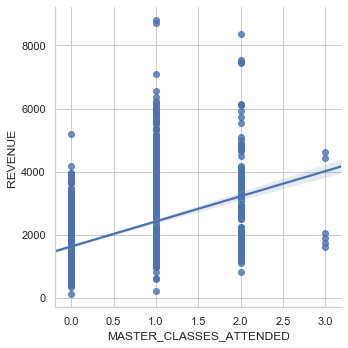

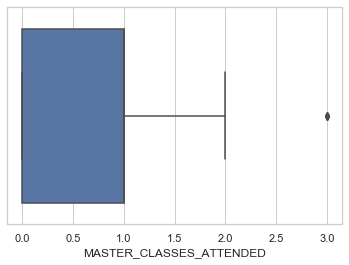

Variable: MEDIAN_MEAL_RATING
------------------------------
3    1087
2     487
4     260
1      99
5      13
Name: MEDIAN_MEAL_RATING, dtype: int64


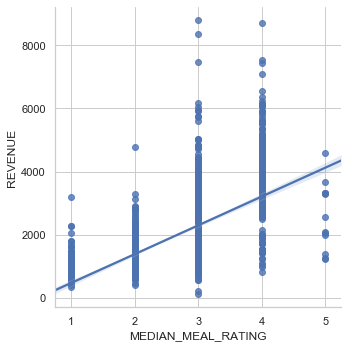

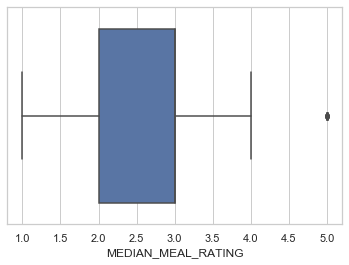

Variable: TOTAL_PHOTOS_VIEWED
------------------------------
0      1140
120      11
180      11
176      11
216      11
       ... 
372       1
375       1
376       1
378       1
261       1
Name: TOTAL_PHOTOS_VIEWED, Length: 371, dtype: int64


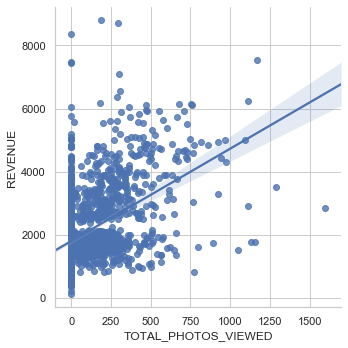

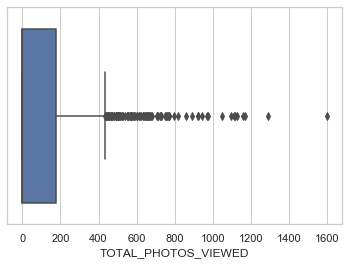

In [183]:
column_types   = original_df.dtypes

columns = [
    'TOTAL_MEALS_ORDERED',                 
    'UNIQUE_MEALS_PURCH',                  
    'CONTACTS_W_CUSTOMER_SERVICE',         
    'AVG_TIME_PER_SITE_VISIT',             
    'PC_LOGINS',                           
    'WEEKLY_PLAN',                         
    'PACKAGE_LOCKER',                      
    'AVG_PREP_VID_TIME',                   
    'LARGEST_ORDER_SIZE',                  
    'MASTER_CLASSES_ATTENDED',             
    'MEDIAN_MEAL_RATING',                  
    'TOTAL_PHOTOS_VIEWED'     
]

for col in columns:
    if (column_types[col] in [np.int64, np.float64, np.uint8]):
        print(f"Variable: {col}")
        print("-"*30)
        print(original_df[col].value_counts(sort=True, ascending = False))
        
        sns.set(style="whitegrid")
        sns.lmplot(
            x    = col,
            y    = "REVENUE",
            data = original_df
        )
        plt.show()
        
        sns.set(style="whitegrid")
        sns.boxplot(
            x    = col,
            data = original_df
        )
        plt.show()

<h1>Creating auxiliary variables</h1>

In [184]:
#FLAGGING OUTLIERS

#CROSS_SELL_SUCCESS
#NO OUTLIER


#TOTAL_MEALS_ORDERED
out_total_meals_ordered = 350

original_df['out_TOTAL_MEALS_ORDERED'] = 0
condition = original_df.loc[0:,'out_TOTAL_MEALS_ORDERED'][original_df['TOTAL_MEALS_ORDERED'] > out_total_meals_ordered]
original_df['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#UNIQUE_MEALS_PURCH
out_unique_meals_purch = 12

original_df['out_UNIQUE_MEALS_PURCH'] = 0
condition = original_df.loc[0:,'out_UNIQUE_MEALS_PURCH'][original_df['UNIQUE_MEALS_PURCH'] > out_unique_meals_purch]
original_df['out_UNIQUE_MEALS_PURCH'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#CONTACTS_W_CUSTOMER_SERVICE
out_contacts_w_customer_service = 12.5

original_df['out_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition = original_df.loc[0:,'out_CONTACTS_W_CUSTOMER_SERVICE'][original_df['CONTACTS_W_CUSTOMER_SERVICE'] > out_contacts_w_customer_service]
original_df['out_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#PRODUCT_CATEGORIES_VIEWED
#NO OUTLIER


#AVG_TIME_PER_SITE_VISIT
out_avg_time_per_site_visit = 190

original_df["out_AVG_TIME_PER_SITE_VISIT"] = 0
condition = original_df.loc[0:,'out_AVG_TIME_PER_SITE_VISIT'][original_df['AVG_TIME_PER_SITE_VISIT'] > out_avg_time_per_site_visit]
original_df['out_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#MOBILE_NUMBER
#NO OUTLIER


#CANCELLATIONS_BEFORE_NOON
out_cancellation_before_noon = 5

original_df["out_CANCELLATIONS_BEFORE_NOON"] = 0
condition = original_df.loc[0:,'out_CANCELLATIONS_BEFORE_NOON'][original_df['CANCELLATIONS_BEFORE_NOON'] > out_cancellation_before_noon]
original_df['out_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#CANCELLATIONS_AFTER_NOON
out_cancellation_after_noon = 0

original_df["out_CANCELLATIONS_AFTER_NOON"] = 0
condition = original_df.loc[0:,'out_CANCELLATIONS_AFTER_NOON'][original_df['CANCELLATIONS_AFTER_NOON'] > out_cancellation_after_noon]
original_df['out_CANCELLATIONS_AFTER_NOON'].replace(to_replace = condition,
                                           value      = 1,
                                           inplace    = True)


#TASTES_AND_PREFERENCES
#NO OUTLIER


#MOBILE_LOGINS
#NO OUTLIER


#PC_LOGINS
#NO OUTLIER


#WEEKLY_PLAN
out_weekly_plan = 31

original_df["out_WEEKLY_PLAN"] = 0
condition = original_df.loc[0:,'out_WEEKLY_PLAN'][original_df['WEEKLY_PLAN'] > out_weekly_plan]
original_df['out_WEEKLY_PLAN'].replace(to_replace = condition,
                              value      = 1,
                              inplace    = True)


#EARLY_DELIVERIES
out_early_deliveries = 7

original_df["out_EARLY_DELIVERIES"] = 0
condition = original_df.loc[0:,'out_EARLY_DELIVERIES'][original_df['EARLY_DELIVERIES'] > out_early_deliveries]
original_df['out_EARLY_DELIVERIES'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)


#LATE_DELIVERIES
out_late_deliveries = 8

original_df["out_LATE_DELIVERIES"] = 0
condition = original_df.loc[0:,'out_LATE_DELIVERIES'][original_df['LATE_DELIVERIES'] > out_late_deliveries]
original_df['out_LATE_DELIVERIES'].replace(to_replace = condition,
                                  value      = 1,
                                  inplace    = True)


#PACKAGE_LOCKER
#NO OUTLIER


#REFRIGERATED_LOCKER
#NO OUTLIER


#FOLLOWED_RECOMMENDATIONS_PCT
#NO OUTLIER


#AVG_PREP_VID_TIME
out_avg_prep_vid_time = 260

original_df["out_AVG_PREP_VID_TIME"] = 0
condition = original_df.loc[0:,'out_AVG_PREP_VID_TIME'][original_df['AVG_PREP_VID_TIME'] > out_avg_prep_vid_time]
original_df['out_AVG_PREP_VID_TIME'].replace(to_replace = condition,
                                    value      = 1,
                                    inplace    = True)


#LARGEST_ORDER_SIZE
out_largest_order_size = 8

original_df["out_LARGEST_ORDER_SIZE"] = 0
condition = original_df.loc[0:,'out_LARGEST_ORDER_SIZE'][original_df['LARGEST_ORDER_SIZE'] > out_largest_order_size]
original_df['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#MASTER_CLASSES_ATTENDED
#NO OUTLIER


#MEDIAN_MEAL_RATING
#NO OUTLIER


#AVG_CLICKS_PER_VISIT
out_avg_clicks_per_visit = 8

original_df["out_AVG_CLICKS_PER_VISIT"] = 0
condition = original_df.loc[0:,'out_AVG_CLICKS_PER_VISIT'][original_df['AVG_CLICKS_PER_VISIT'] < out_avg_clicks_per_visit]
original_df['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition, 
                                          value      = 1, 
                                          inplace    = True)


#TOTAL_PHOTOS_VIEWED
out_total_photos_viewed = 420

original_df["out_TOTAL_PHOTOS_VIEWED"] = 0
condition = original_df.loc[0:,'out_TOTAL_PHOTOS_VIEWED'][original_df['TOTAL_PHOTOS_VIEWED'] > out_total_photos_viewed]
original_df['out_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition, 
                                          value      = 1, 
                                          inplace    = True)

#FLAGGING TRENDS

#Trend Change

#CROSS_SELL_SUCCESS
#NO TREND

#TOTAL_MEALS_ORDERED
tot_meals_seg_change = 20

original_df['TOTAL_MEALS_ORDERED_change'] = 0
condition = original_df.loc[0:,'TOTAL_MEALS_ORDERED_change'][original_df['TOTAL_MEALS_ORDERED'] < tot_meals_seg_change]
original_df['TOTAL_MEALS_ORDERED_change'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#UNIQUE_MEALS_PURCH
unique_meals_purch_change = 1

original_df['UNIQUE_MEALS_PURCH_change'] = 0
condition = original_df.loc[0:,'UNIQUE_MEALS_PURCH_change'][original_df['UNIQUE_MEALS_PURCH'] <= unique_meals_purch_change]
original_df['UNIQUE_MEALS_PURCH_change'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#CONTACTS_W_CUSTOMER_SERVICE
contacts_w_customer_service_change = 10

original_df['CONTACTS_W_CUSTOMER_SERVICE_change'] = 0
condition = original_df.loc[0:,'CONTACTS_W_CUSTOMER_SERVICE_change'][original_df['CONTACTS_W_CUSTOMER_SERVICE'] <= contacts_w_customer_service_change]
original_df['CONTACTS_W_CUSTOMER_SERVICE_change'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#PRODUCT_CATEGORIES_VIEWED
#NO TREND


#AVG_TIME_PER_SITE_VISIT
#NO TREND

#MOBILE_NUMBER
#NO TREND


#CANCELLATIONS_BEFORE_NOON
#NO TREND


#CANCELLATIONS_AFTER_NOON
#NO TREND


#TASTES_AND_PREFERENCES
#NO TREND


#MOBILE_LOGINS
#NO TREND


#PC_LOGINS
#NO TREND

#WEEKLY_PLAN
#NO TREND


#EARLY_DELIVERIES
#NO TREND


#LATE_DELIVERIES
#NO TREND


#PACKAGE_LOCKER
#NO TREND


#REFRIGERATED_LOCKER
#NO TREND


#FOLLOWED_RECOMMENDATIONS_PCT
#NO TREND


#AVG_PREP_VID_TIME
#NO TREND


#LARGEST_ORDER_SIZE
#NO TREND


##MASTER_CLASSES_ATTENDED
master_classes_attended_change = 2

original_df["MASTER_CLASSES_ATTENDED_change"] = 0
condition = original_df.loc[0:,'MASTER_CLASSES_ATTENDED_change'][original_df['MASTER_CLASSES_ATTENDED'] > master_classes_attended_change]
original_df['MASTER_CLASSES_ATTENDED_change'].replace(to_replace = condition,
                               value      = 1,
                               inplace    = True)


#MEDIAN_MEAL_RATING#MEDIAN_MEAL_RATING
out_median_meal_rating = 2

original_df["out_MEDIAN_MEAL_RATING"] = 0
condition = original_df.loc[0:,'out_MEDIAN_MEAL_RATING'][original_df['MEDIAN_MEAL_RATING'] > out_median_meal_rating]
original_df['out_MEDIAN_MEAL_RATING'].replace(to_replace = condition,
                                     value      = 1,
                                     inplace    = True)


#AVG_CLICKS_PER_VISIT
#NO TREND


#TOTAL_PHOTOS_VIEWED
total_photos_viewed_change = 0

original_df['TOTAL_PHOTOS_VIEWED_change_1'] = 0
condition = original_df.loc[0:,'TOTAL_PHOTOS_VIEWED_change_1'][original_df['TOTAL_PHOTOS_VIEWED'] == total_photos_viewed_change]
original_df['TOTAL_PHOTOS_VIEWED_change_1'].replace(to_replace = condition, 
                                         value      = 1, 
                                         inplace    = True)

total_photos_viewed_change = 1000

original_df['TOTAL_PHOTOS_VIEWED_change_2'] = 0
condition = original_df.loc[0:,'TOTAL_PHOTOS_VIEWED_change_2'][original_df['TOTAL_PHOTOS_VIEWED'] > total_photos_viewed_change]
original_df['TOTAL_PHOTOS_VIEWED_change_2'].replace(to_replace = condition, 
                                         value      = 1, 
                                         inplace    = True)


#HAS EMAIL
original_df["EMAIL_DOMAIN"] = pd.DataFrame(original_df["EMAIL"].apply(str.split, sep = "@").to_list()).iloc[:,1]
original_df["EMAIL_TYPE"]   = original_df["EMAIL_DOMAIN"].apply(set_EmailType)
original_df = pd.concat([original_df, pd.get_dummies(original_df["EMAIL_TYPE"])], axis = 1)
original_df = original_df.drop(["EMAIL_DOMAIN","EMAIL_TYPE"], axis=1)

has_email = 1

original_df['HAS_EMAIL'] = 1
condition = original_df.loc[0:,'HAS_EMAIL'][original_df['junk'] == has_email]
original_df['HAS_EMAIL'].replace(to_replace = condition, 
                                         value      = 0, 
                                         inplace    = True)

<h1>Looking for the appropiate model</h1>

In [185]:
import inspect
import sklearn.linear_model
from sklearn.model_selection import train_test_split

def GetRegressors():
    lst_class = []

    for name, obj in inspect.getmembers(sklearn.linear_model):
        if inspect.isclass(obj):
            if("Logistic" not in name):
                try:
                    class_ = getattr(sklearn.linear_model, name)
                    instance = class_()

                    lst_class.append([name, instance])
                except:
                    continue
    return lst_class

SEED      = 222
TEST_SIZE = 0.25

x_variables = [
    'CROSS_SELL_SUCCESS', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH',
    'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
    'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
    'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'MOBILE_LOGINS',
    'PC_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES',
    'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
    'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
    'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED',
    'out_TOTAL_MEALS_ORDERED', 'out_UNIQUE_MEALS_PURCH', 'out_CONTACTS_W_CUSTOMER_SERVICE',
    'out_AVG_TIME_PER_SITE_VISIT', 'out_CANCELLATIONS_BEFORE_NOON',
    'out_CANCELLATIONS_AFTER_NOON', 'out_WEEKLY_PLAN',
    'out_EARLY_DELIVERIES', 'out_LATE_DELIVERIES', 'out_AVG_PREP_VID_TIME',
    'out_LARGEST_ORDER_SIZE', 'out_AVG_CLICKS_PER_VISIT',
    'out_TOTAL_PHOTOS_VIEWED', 'TOTAL_MEALS_ORDERED_change',
    'UNIQUE_MEALS_PURCH_change', 'CONTACTS_W_CUSTOMER_SERVICE_change',
    'MASTER_CLASSES_ATTENDED_change', 'out_MEDIAN_MEAL_RATING',
    'TOTAL_PHOTOS_VIEWED_change_1', 'TOTAL_PHOTOS_VIEWED_change_2',
    'HAS_EMAIL'
]

X = original_df.loc[:,x_variables]
y = original_df.loc[:,"REVENUE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEED)

lst_class = GetRegressors()

i = 0
for reg_class in lst_class:
    try:
        if reg_class[0] != "ARDRegression":
            linear_mod = reg_class[1]
            linear_mod.fit(X_train, y_train)
            y_pred = linear_mod.predict(X_test)

            train_score_linear_mod = linear_mod.score(X_train, y_train).round(3)
            test_score_linear_mod = linear_mod.score(X_test, y_test).round(3)

            print(f"Model {i}: {reg_class[0]}")
            print(f"\tTrain Score for {reg_class[0]}: {train_score_linear_mod}")
            print(f"\tTest Score for {reg_class[0]}: {test_score_linear_mod}")
    except:
        print(f"Error in class {reg_class[0]}")
    i += 1

Model 1: BayesianRidge
	Train Score for BayesianRidge: 0.767
	Test Score for BayesianRidge: 0.697
Model 2: ElasticNet
	Train Score for ElasticNet: 0.665
	Test Score for ElasticNet: 0.581
Model 3: ElasticNetCV
	Train Score for ElasticNetCV: 0.572
	Test Score for ElasticNetCV: 0.48
Error in class Hinge


C:\Users\Andre\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Andre\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=2.722e-02, with an active set of 44 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


Model 5: HuberRegressor
	Train Score for HuberRegressor: 0.654
	Test Score for HuberRegressor: 0.563
Model 6: Lars
	Train Score for Lars: 0.77
	Test Score for Lars: 0.697
Model 7: LarsCV
	Train Score for LarsCV: 0.764
	Test Score for LarsCV: 0.694
Model 8: Lasso
	Train Score for Lasso: 0.767
	Test Score for Lasso: 0.699
Model 9: LassoCV
	Train Score for LassoCV: 0.624
	Test Score for LassoCV: 0.534
Model 10: LassoLars
	Train Score for LassoLars: 0.737
	Test Score for LassoLars: 0.668
Model 11: LassoLarsCV
	Train Score for LassoLarsCV: 0.764
	Test Score for LassoLarsCV: 0.694
Model 12: LassoLarsIC
	Train Score for LassoLarsIC: 0.756
	Test Score for LassoLarsIC: 0.687
Model 13: LinearRegression
	Train Score for LinearRegression: 0.77
	Test Score for LinearRegression: 0.697
Error in class Log
Error in class ModifiedHuber
Error in class MultiTaskElasticNet
Error in class MultiTaskElasticNetCV
Error in class MultiTaskLasso
Error in class MultiTaskLassoCV
Model 20: OrthogonalMatchingPursuit


<h1>Main takeaways </h1>
<p>The plot hints that a logarithmic transformation to the dependent variable may help to increase accuracy
<p>Unnecessary variables won't be included in the final model
<p>The first run of multiple models indicates that is needed a better variable selection
<p>Hyperparameter tunning for Lasso and Ridge regression didn't help to improve the score
<p>K-Nearest Neighbors did not gave a good score with the selected variables